In [ ]:
## Ideas

## Implement VEC curve & contour plots
## A Variable Effect Characteristic (VEC) curve:
## plots the the xa,j values (x-axis) versus the (average, if Equation is 2 used) yˆa,j responses (y-axis)

## A method to quantify these changes into a single metrix is with SA. Define a sensitivity function (1)
## Then, use the Relative Importance (2) to quantify

## SA can produce input importances shown with bar plots:
## Input Importances: To show the input importances, we propose a bar plot with the R_a importances

# Feature importance
# training on garbage


## My Idea
## Can you do specific hypothesis testing with changes in features if you bootstrap distributions

# Reference Paper Formulas

## (1)

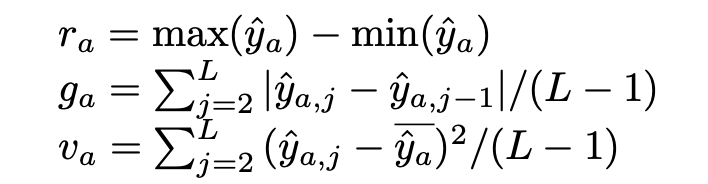

## (2)

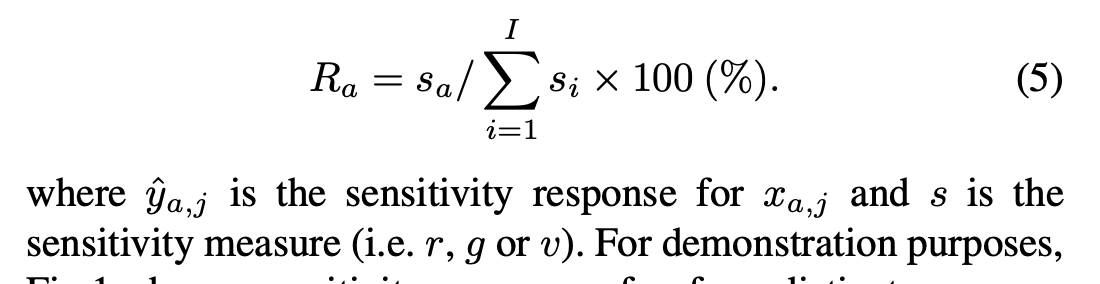

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [123]:
path = "https://raw.githubusercontent.com/shrikant-temburwar/Wine-Quality-Dataset/master/winequality-red.csv"
df_r = pd.read_csv(path,delimiter=";")
#df_r['Color'] = 1

path = "https://raw.githubusercontent.com/shrikant-temburwar/Wine-Quality-Dataset/master/winequality-white.csv"
df_w = pd.read_csv(path,delimiter=";")
df_w['Color'] = 0
#df = df_r.append(df_w)
df = df_r

# https://saattrupdan.github.io/2020-03-01-bootstrap-prediction/
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
def feature_scores(data,target,feature,nodes,base=False):
  df = data.copy()
  y_train = df[f'{target}']
  X_train = df.loc[:, df.columns != f'{target}']

  # Bootstrap #
  n = X_train.shape[0]
  train_idxs = np.random.choice(range(n), size = n, replace = True)
  #val_idxs = np.array([idx for idx in range(n) if idx not in train_idxs])
  #X_train.iloc[train_idxs,:]
  #y_train[train_idxs]
  ##############

  # Instantiate model
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(nodes, input_shape=(X_train.shape[1],),activation='relu'))
  model.add(tf.keras.layers.Dense(nodes,activation = 'relu'))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

  # Fit model
  history = model.fit(
      X_train.iloc[train_idxs, :], 
      y_train[train_idxs],
      verbose = 0,
      epochs=100)

  if base == True:
    avg_set = X_train.describe().T['mean'].to_numpy()
    base_pred =[]
    base = model.predict(avg_set.reshape(1,-1))
    null = float(base)
    base_pred.append(null)
    print("Fitting Base Prediction")
    #print(base_pred)
    return base_pred

  else:
    print(f"Fitting {feature} Standard Devation Changes..")
    stdev = X_train.describe().T['std']
    avg_set = X_train.describe().T['mean']
    feat_stdev = stdev[f'{feature}']
    stdevs = feat_stdev*np.linspace(-1,1,21)
    stdevs = np.delete(stdevs, 10)
    feat_preds = []
    for i in range(len(stdevs)):
      print(i)
      avg_set[avg_set.index == f'{feature}'] = avg_set[avg_set.index == f'{feature}'] + stdevs[i]
      predict_set = avg_set.to_numpy()
      feat_preds.append(model.predict(predict_set.reshape(1,-1)))

    return feat_preds


# First Attempt

In [ ]:
def feature_scores(data,target,nodes,plot=False,base=False):
  df = data.copy()
  y_train = df[f'{target}']
  X_train = df.loc[:, df.columns != f'{target}']
  
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(nodes, input_shape=(X_train.shape[1],),activation='relu'))
  model.add(tf.keras.layers.Dense(nodes,activation = 'relu'))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

  history = model.fit(
      X_train.iloc[train_idxs, :], y_train[train_idxs]),
      #validation_split=0.2, 
      verbose = 0,
      epochs=100)
  

  # Only works if validation is on
  if plot == True:
    
    def plot_loss(history):
      plt.plot(history.history['loss'], label='loss')
      plt.plot(history.history['val_loss'], label='val_loss')
      plt.ylim([0, 5])
      plt.xlabel('Epoch')
      plt.ylabel('Error')
      plt.legend()
      plt.grid(True)
    print(plot_loss(history))

  avg_set = X_train.describe().T['mean'].to_numpy()
  stdev = X_train.describe().T['std'].to_numpy()

  info = []
  for idx, i in enumerate(stdev):
    null = np.zeros(stdev.shape[0])
    null[idx] = i
    info.append(null)

  design = []
  for i in range(avg_set.shape[0]):
    null = avg_set + info[i]
    design.append(null)
  
  if base ==True:
    base_pred =[]
    base = model.predict(avg_set.reshape(1,-1))
    null = float(base)
    base_pred.append(null)
    print(base_pred)
    return base_pred
  
  else:
    preds = []
    for i in range(len(design)):
      preds.append(model.predict(design[i].reshape(1,-1)))

    #scores = base - preds
    out = []
    for i in preds:
      null = float(i)
      out.append(null)

    print(out)
    return out
  

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, input_shape=(train_features.shape[1],),activation='relu'))
model.add(tf.keras.layers.Dense(64,activation = 'relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

history = model.fit(
    train_features, train_labels,
    validation_split=0.2, verbose = 0,
    epochs=100)

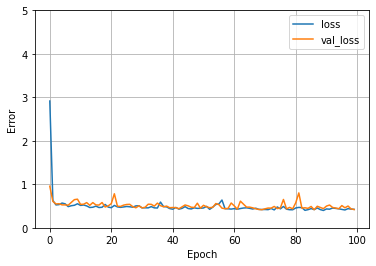

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 5])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
# Bootstrap
n = X_train.shape[0]
nbootstraps = np.sqrt(n).astype(int)


avg_set = train_features.describe().T['mean'].to_numpy()
stdev = train_features.describe().T['std'].to_numpy()
# I need pxp matrix where each step includes all zeros except one value, in order
info = []
for idx, i in enumerate(stdev):
  null = np.zeros(stdev.shape[0])
  null[idx] = i
  info.append(null)

# could test for linear & nonlinear effect
# one standard deviation up & down, is it linear?
design = []
for i in range(avg_set.shape[0]):
  null = avg_set + info[i]
  design.append(null)

base = model.predict(avg_set.reshape(1,-1))

preds = []
for i in range(len(design)):
  preds.append(model.predict(design[i].reshape(1,-1)))
  
scores = base - preds
out = []
for i in preds:
  null = float(i)
  out.append(null)


# Loop

In [ ]:
# distribution of Base Y Hat
dat_base = pd.DataFrame({
    "Base Predictions": []
})
N = 25
for i in range(N):
  dat_base.loc[len(dat_base), :] = feature_scores(df,'quality',"NA",20,base=True)

In [ ]:
# pH
cols = np.linspace(-1,1,21)
cols = np.delete(cols, 10)
dat = pd.DataFrame(columns = np.round(cols,decimals=4))
N = 25
for i in range(N):
  dat.loc[len(dat), :] = np.concatenate(feature_scores(df,'quality','pH',20,base=False)).reshape(1,-1)

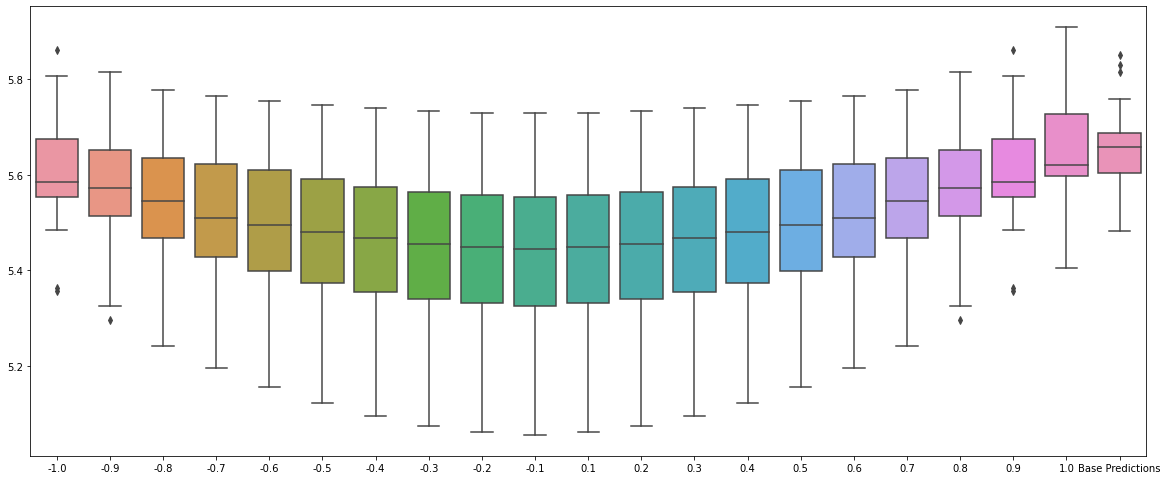

In [ ]:
#pH
#dat.columns = np.round(cols,decimals=4)
info = pd.concat([dat,dat_base],axis=1)
a4_dims = (20, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(data=info);

In [ ]:
# chlorides
cols = np.linspace(-1,1,21)
cols = np.delete(cols, 10)
dat = pd.DataFrame(columns = np.round(cols,decimals=4))
N = 25
for i in range(N):
  dat.loc[len(dat), :] = np.concatenate(feature_scores(df,'quality','chlorides',20,base=False)).reshape(1,-1)

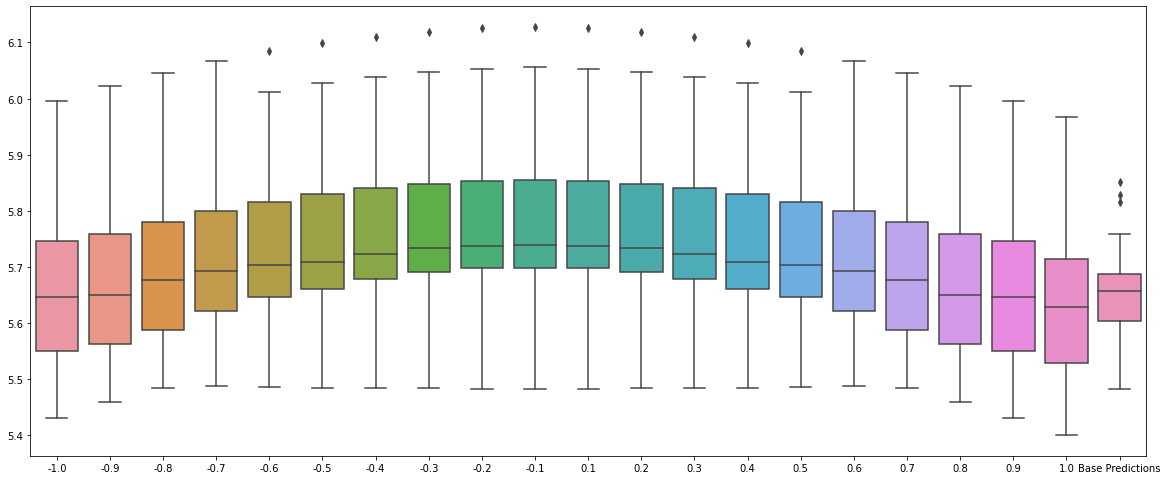

In [ ]:
# chlorides
#dat.columns = np.round(cols,decimals=4)
info = pd.concat([dat,dat_base],axis=1)
a4_dims = (20, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(data=info);


In [ ]:
# fixed acidity
cols = np.linspace(-1,1,21)
cols = np.delete(cols, 10)
dat = pd.DataFrame(columns = np.round(cols,decimals=4))
N = 25
for i in range(N):
  dat.loc[len(dat), :] = np.concatenate(feature_scores(df,'quality','fixed acidity',20,base=False)).reshape(1,-1)

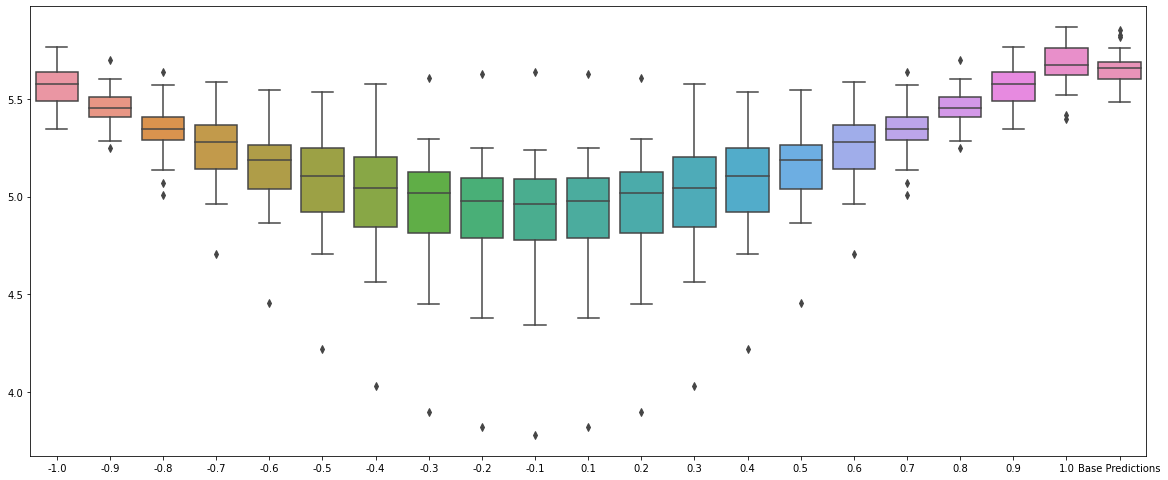

In [ ]:
# fixed acidity
#dat.columns = np.round(cols,decimals=4)
info = pd.concat([dat,dat_base],axis=1)
a4_dims = (20, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(data=info);


# VEC

In [63]:
def vec(data,target,nodes,var):
  df = data.copy()
  y_train = df[f'{target}']
  X_train = df.loc[:, df.columns != f'{target}']

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(nodes, input_shape=(X_train.shape[1],),activation='relu'))
  model.add(tf.keras.layers.Dense(nodes,activation = 'relu'))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  
  history = model.fit(
      X_train, 
      y_train,
      verbose = 0,
      epochs=100)
  
  var_eff = df[f'{var}']
  var_vals = np.round(np.percentile(df[f'{var}'],np.arange(0, 100, 10)),2)
  preds =[]
  print(f"Predict with {var}'s deciles")
  for i in range(len(var_vals)):
    avg_set = X_train.describe().T['mean']
    avg_set[f'{var}'] = var_vals[i]
    avg_set = avg_set.to_numpy()
    mod = model.predict(avg_set.reshape(1,-1))
    null = float(mod)
    preds.append(null)
  return preds, var_vals

In [62]:
lis, vals = vec(df,'quality',20,'volatile acidity')

Predict with volatile acidity's deciles'


In [ ]:
fig, ax = plt.subplots(1,figsize=(12,12))
ax.plot(vals,lis)
ax.set(xlabel='Volatile Acidity Values', ylabel='Quality Predictions',
       title='[]')
ax.grid()
plt.show();

In [ ]:
lis, vals = vec(df,'quality',20,'pH')

In [ ]:
fig, ax = plt.subplots(1,figsize=(12,12))
ax.plot(vals,lis)
ax.set(xlabel='pH Values', ylabel='Quality Predictions',
       title='[]')
ax.grid()
plt.show();

# VEC with average response

In [85]:
def vec_ave(data,target,nodes,var):
  df = data.copy()
  y_train = df[f'{target}']
  X_train = df.loc[:, df.columns != f'{target}']

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(nodes, input_shape=(X_train.shape[1],),activation='relu'))
  model.add(tf.keras.layers.Dense(nodes,activation = 'relu'))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  
  history = model.fit(
      X_train, 
      y_train,
      verbose = 0,
      epochs=100)
  
  
  var_vals = np.round(np.percentile(df[f'{var}'],np.arange(0, 100, 10)),2)
  preds =[]
  print(f"Average Prection with {var}'s deciles") 
  for i in range(len(var_vals)):
    X_train[f'{var}'] = var_vals[i]
    mod = model.predict(X_train.to_numpy())
    null = np.mean(mod)
    preds.append(null)
  return preds, var_vals

In [ ]:
lis,vals = vec_ave(df,'quality',20,'volatile acidity')
fig, ax = plt.subplots(1,figsize=(12,12))
ax.plot(vals,lis)
ax.set(xlabel='Volatile Acidity Values', ylabel='Quality Predictions',
       title='[]')
ax.grid()
plt.show();

In [ ]:
lis,vals = vec_ave(df,'quality',20,'alcohol')
fig, ax = plt.subplots(1,figsize=(12,12))
ax.plot(vals,lis)
ax.set(xlabel='Alcohol Values', ylabel='Quality Predictions',
       title='[]')
ax.grid()
plt.show();

In [ ]:
lis,vals = vec_ave(df,'quality',20,'sulphates')
fig, ax = plt.subplots(1,figsize=(12,12))
ax.plot(vals,lis)
ax.set(xlabel='Sulphate Values', ylabel='Quality Predictions',
       title='[]')
ax.grid()
plt.show();

# VEC with all predictors

In [246]:
features = df.loc[:, df.columns != 'quality']

def scale(data,center=True):
  df = data.copy()
  if center:
    for i in range(df.shape[1]):
      df.iloc[:,i] = (df.iloc[:,i] - np.mean(df.iloc[:,i])) / np.std(df.iloc[:,i])
    return df
  else:
    for i in range(df.shape[1]):
      df.iloc[:,i] = (df.iloc[:,i] - np.min(df.iloc[:,i])) / (np.max(df.iloc[:,i])- np.min(df.iloc[:,i]))
    return df


def vec_all(data,target,nodes,average=False):
  df = data.copy()
  y_train = df[f'{target}']
  X_train = df.loc[:, df.columns != f'{target}']
  X_train = scale(X_train,center=False)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(nodes, input_shape=(X_train.shape[1],),activation='relu'))
  model.add(tf.keras.layers.Dense(nodes,activation = 'relu'))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  
  history = model.fit(
      X_train, 
      y_train,
      verbose = 0,
      epochs=100)
  
  
  x_axis = np.linspace(0,1,num = 30)
  
  if average == False:
    frame = pd.DataFrame(0, index=range(len(x_axis)), columns=X_train.columns)
    for i in range(len(x_axis)):
      for j in range(X_train.shape[1]):
        avg_set = X_train.describe().T['mean']
        avg_set[X_train.columns[j]] = x_axis[i]
        avg_set = avg_set.to_numpy()
        mod = model.predict(avg_set.reshape(1,-1))
        frame.iloc[i:i+1,j:j+1] = mod
    return frame

  else:
    frame = pd.DataFrame(0, index=range(len(x_axis)), columns=X_train.columns)
    for i in range(len(x_axis)):
      for j in range(len(X_train.columns)):
        newset = X_train.copy()
        newset[newset.columns[j]] = x_axis[i]
        mod = model.predict(newset.to_numpy())
        null = np.mean(mod)
        frame.iloc[i:i+1,j:j+1] = null
    return frame

In [231]:
temp = vec_all(df,'quality',20,average=False)

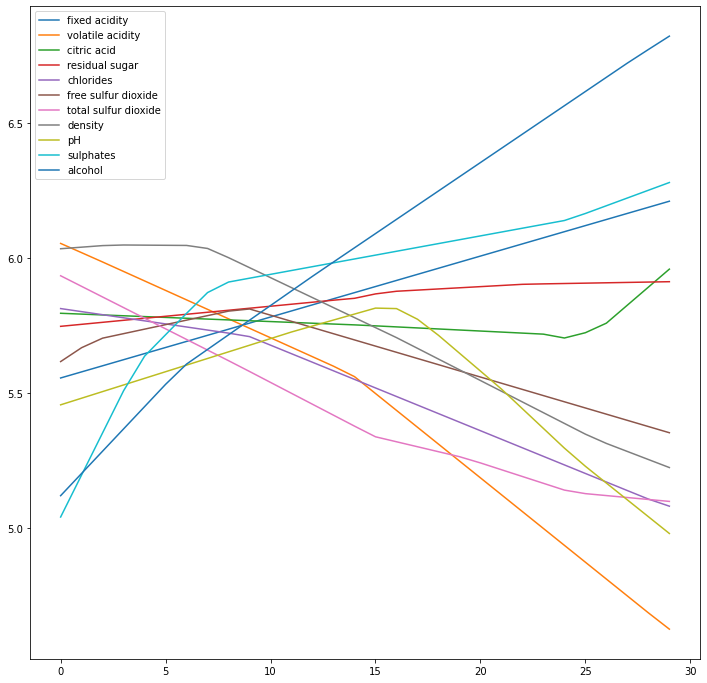

In [240]:
temp.plot(figsize=(12,12));

In [247]:
temp = vec_all(df,'quality',20,average=True)

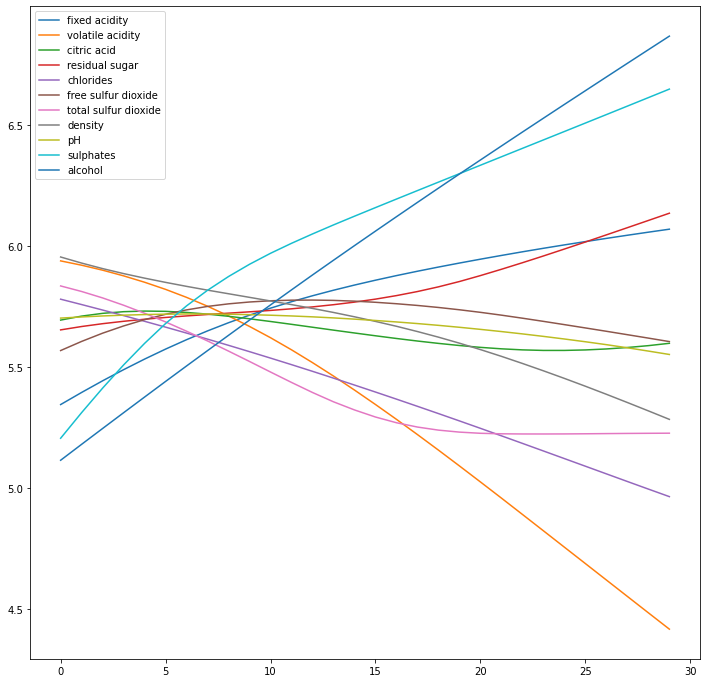

In [248]:
temp.plot(figsize=(12,12));

# Miscellaneous

In [ ]:
x_axis = np.linspace(0,1,num = 30)
frame = pd.DataFrame(0, index=range(len(x_axis)), columns=features.columns)

for i in range(len(x_axis)):
  for j in range(len(features.columns)):
    frame.iloc[i:i+1,j:j+1] = 2
features.loc[features.columns[0]] = x_axis[1]
features

frame.iloc[1:2,2:3] = 3
frame

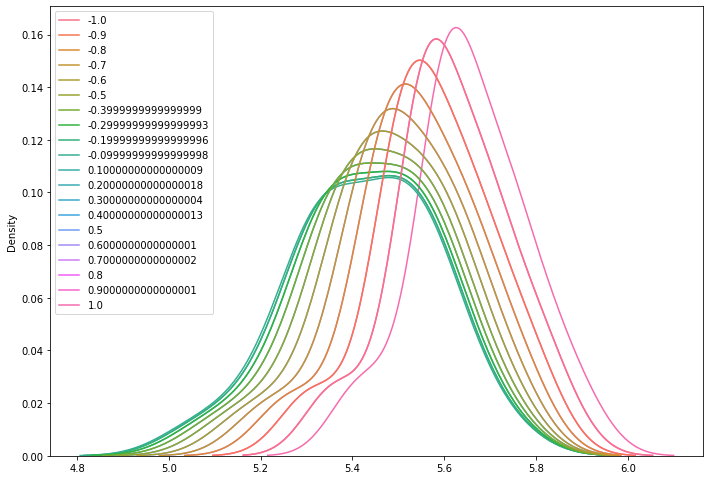

In [ ]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.kdeplot(data = dat.astype(float));

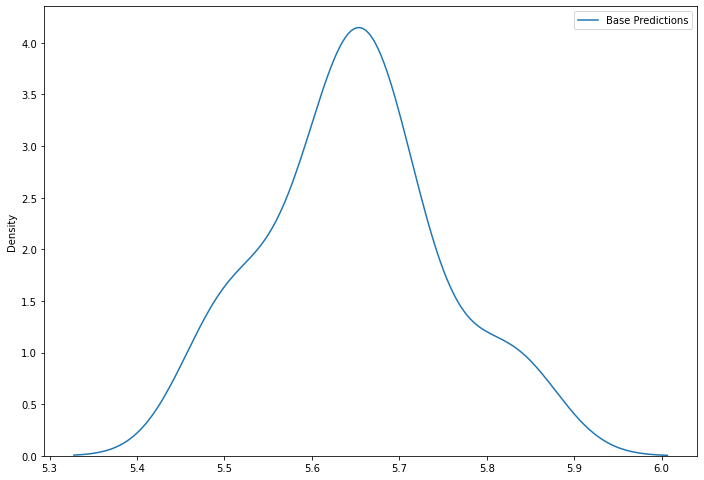

In [ ]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.kdeplot(data = dat_base.astype(float));

In [ ]:
### Bootstrap Example ###

def prediction_interval(model, X_train, y_train, x0, alpha: float = 0.05):
  ''' Compute a prediction interval around the model's prediction of x0.

  INPUT
    model
      A predictive model with `fit` and `predict` methods
    X_train: numpy array of shape (n_samples, n_features)
      A numpy array containing the training input data
    y_train: numpy array of shape (n_samples,)
      A numpy array containing the training target data
    x0
      A new data point, of shape (n_features,)
    alpha: float = 0.05
      The prediction uncertainty

  OUTPUT
    A triple (`lower`, `pred`, `upper`) with `pred` being the prediction 
    of the model and `lower` and `upper` constituting the lower- and upper 
    bounds for the prediction interval around `pred`, respectively. '''

  # Number of training samples
  n = X_train.shape[0]

  # The authors choose the number of bootstrap samples as the square root 
  # of the number of samples
  nbootstraps = np.sqrt(n).astype(int)

  # Compute the m_i's and the validation residuals
  bootstrap_preds, val_residuals = np.empty(nbootstraps), []
  for b in range(nbootstraps):
    train_idxs = np.random.choice(range(n), size = n, replace = True)
    val_idxs = np.array([idx for idx in range(n) if idx not in train_idxs])
    model.fit(X_train[train_idxs, :], y_train[train_idxs])
    preds = model.predict(x_train[val_idxs])
    val_residuals.append(y_train[val_idxs] - preds)
    bootstrap_preds[b] = model.predict(x0)
  bootstrap_preds -= np.mean(bootstrap_preds)
  val_residuals = np.concatenate(val_residuals)

  # Compute the prediction and the training residuals
  model.fit(X_train, y_train)
  preds = model.predict(X_train)
  train_residuals = y_train - preds

  # Take percentiles of the training- and validation residuals to enable 
  # comparisons between them
  val_residuals = np.percentile(val_residuals, q = np.arange(100))
  train_residuals = np.percentile(train_residuals, q = np.arange(100))

  # Compute the .632+ bootstrap estimate for the sample noise and bias
  no_information_error = np.mean(np.abs(np.random.permutation(y_train) - \
    np.random.permutation(preds)))
  generalisation = np.abs(val_residuals - train_residuals)
  no_information_val = np.abs(no_information_error - train_residuals)
  relative_overfitting_rate = np.mean(generalisation / no_information_val)
  weight = .632 / (1 - .368 * relative_overfitting_rate)
  residuals = (1 - weight) * train_residuals + weight * val_residuals

  # Construct the C set and get the percentiles
  C = np.array([m + o for m in bootstrap_preds for o in residuals])
  qs = [100 * alpha / 2, 100 * (1 - alpha / 2)]
  percentiles = np.percentile(C, q = qs)
  
  return percentiles[0], model.predict(x0), percentiles[1]